## Кластеризация текстов: описания благотворительных сборов на planeta.ru

(изначально написан в pycharm)

Top terms per cluster:

 Cluster 0:
больница
малыш
ребёнок
детка
няня
отделение
архангельский
новорождённый
неравнодушный
тёплый

 Cluster 1:
курс
реабилитация
ребёнок
мама
лечение
дцп
ходить
очень
мальчик
диагноз

 Cluster 2:
спорт
спортсмен
соревнование
чемпионат
турнир
коляска
спортивный
точка
бочч
опора

 Cluster 3:
приют
вольер
животное
кошка
собака
бездомный
р
строительство
животный
дом

 Cluster 4:
человек
хоспис
жизнь
социальный
работа
инвалид
мочь
дом
организация
ребёнок

 Cluster 5:
ребёнок
подарок
новогодний
бабушка
отделение
праздник
дедушка
мороз
дед
пожилое

 Cluster 6:
фестиваль
спектакль
ребёнок
праздник
театр
человек
подарок
творческий
гость
участник

 Cluster 7:
приют
животное
собака
бездомный
кошка
животный
вольер
стерилизация
ветеринарный
питомец

 Cluster 8:
аутизм
ребёнок
лагерь
ребята
человек
школа
родитель
антон
занятие
ресурсный

 Cluster 9:
ребёнок
лечение
маша
курс
дцп
реабилитация
центр
занятие
диагноз
мама

 Cluster 10:
ребёнок
детский
семья
дом
родитель
за

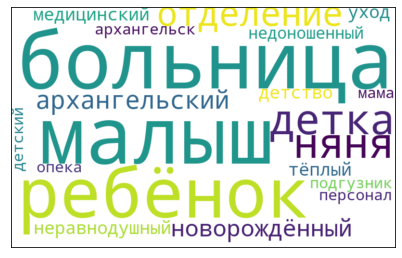

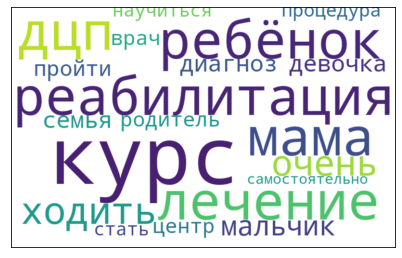

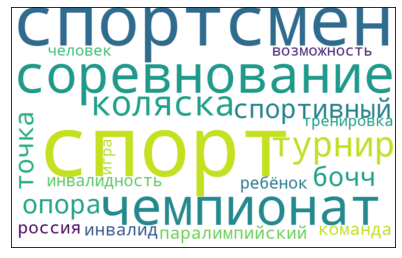

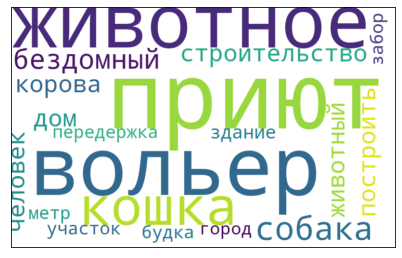

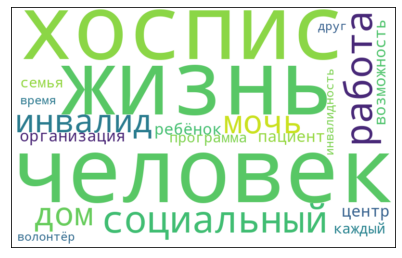

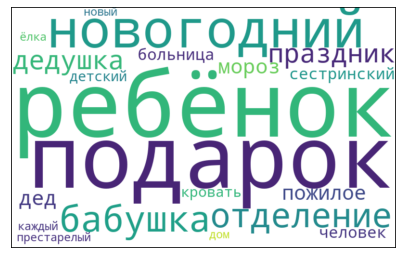

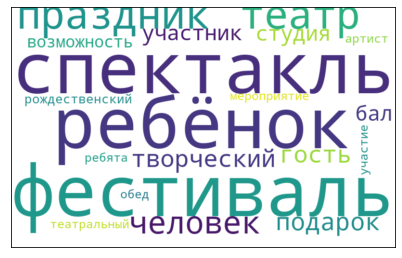

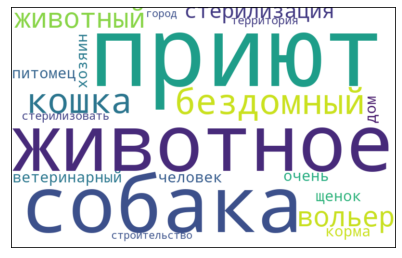

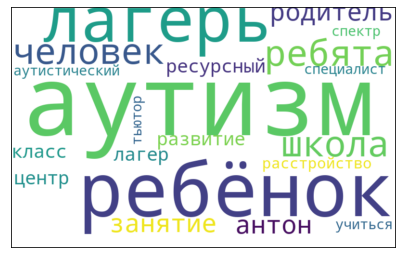

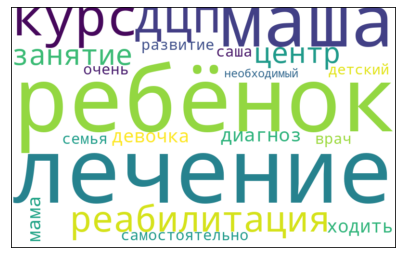

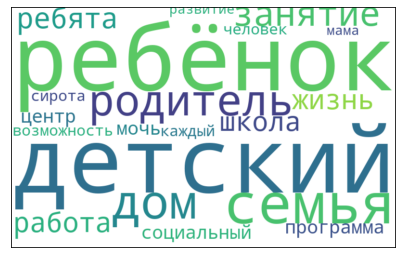

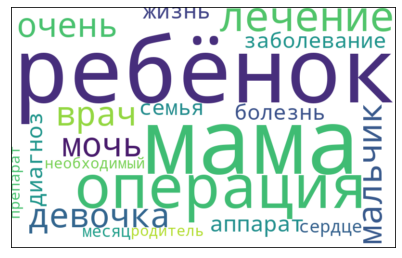

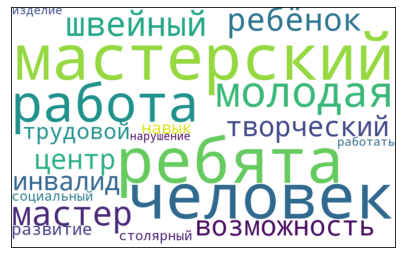

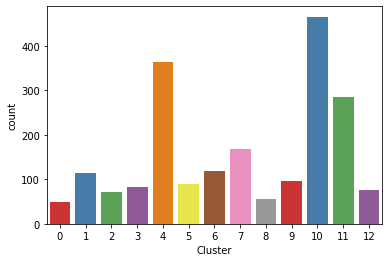


 Кластер 0: 50
1      Сбор средств на оплату ухода за детьми-сиротам...
2      Сбор средств на уход за детьми-отказниками в б...
10     Для детей, оставшихся без попечения и попавших...
37     Помощь детям-сиротам Тамбова и Тамбовской обла...
58     Диагноз: перенесенная гипоксия тяжелой формы с...
125    Сбор пожертвований для организации ухода за де...
133    Фонд "Бюро Добрых Дел" собирает средства на ме...
Name: Briefly, dtype: object

 Кластер 1: 114
15     Реабилитационный курс для мальчика с детский ц...
27     Марк – мечтает танцевать. Ему 4 года и он гото...
63     Благотворительный фонд «Галчонок» собирает сре...
104    Благотворительный фонд «Галчонок» собирает сре...
117    БФ «Галчонок» помогает Алёше с ДЦП собрать сре...
200    У Глеба капиллярная ангиодисплазия правой щеки...
201    Диагноз Карины ДЦП. Она ещё не умеет ходить, н...
Name: Briefly, dtype: object

 Кластер 2: 72
54     Петербургской команде по академической гребле ...
55     Молодым боччеистам с ДЦП Ивану 

In [1]:
import re
from string import digits
import pandas as pd
import pymorphy2
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud

morph_analyzer = pymorphy2.MorphAnalyzer()
pd.options.display.max_columns = 15
stop_words = stopwords.words('russian')
stop_words.extend(['это', '–', '-', 'фонд', 'наш', 'помощь', 'помогать',
                   'помочь', 'поддержать', 'поддержка', 'средство', 'который', 'весь',
                   'благотворительный', 'деньги', 'рубль', 'год', 'день', 'тысяча',
                   'ваш', 'сегодня', 'завтра', 'этот', 'дать', 'проект', 'свой' ])
#это очень частотные слова для данной коолекции текстов

def prep(text):
    clean_text = text.translate(str.maketrans('', '', '!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~«»№!—'))
    clean_text = clean_text.translate(str.maketrans('', '', digits))
    clean_text = re.sub("-", " ", clean_text)
    clean_text = re.sub("NaN", "", clean_text)
    clean_text = re.sub("[a-zA-Z]", "", clean_text)  # исключаем слова латиницей
    clean_text = clean_text.lower()
    clean_text = clean_text.split()
    lemmas = [morph_analyzer.parse(word)[0].normal_form for word in clean_text]
    lemmas = [word for word in lemmas if word not in stop_words]
    return lemmas


def vec_model(text):
    vec = TfidfVectorizer(tokenizer=prep)
    bowed_texts = vec.fit_transform(text)
    model = KMeans(n_clusters=13, init='k-means++', max_iter=100, n_init=1, random_state=37)
    model = model.fit(bowed_texts)
    print("Top terms per cluster:")
    order_centroids = model.cluster_centers_.argsort()[:, ::-1]  # индексы слов, по мере убывания близости к центру
    terms = vec.get_feature_names()  # массив слов в том порядке, в котором их помнит kmeans
    for i in range(13):
        print("\n", "Cluster %d:" % i)
        for ind in order_centroids[i, :10]:  # печатаем 10 самых близких
            print(terms[ind])

    list = []
    for i in range(13):
        list_ins = []
        for ind in order_centroids[i, :20]:
            list_ins.append(terms[ind])
        list.append(list_ins)

    #print(list)
    for item in list:
        item = " ".join(item)
        wordcloud = WordCloud(width=800, height=500, background_color="white").generate(item)
        plt.figure()
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.tight_layout()
        frame = plt.gca()
        frame.axes.get_xaxis().set_ticks([])
        frame.axes.get_yaxis().set_ticks([])
        plt.show()

    return model.labels_


def df_upd(df):
    df = df.assign(Cluster=vec_model(text))
    return df

if __name__ == "__main__":
    df = pd.read_csv('plset_fin_upd.csv')
    df.dropna(subset=["Description"], inplace=True)
    text = df['Description'].values.astype('U')
    df = df_upd(df)
    sns.countplot(x=df['Cluster'], data=df, palette="Set1")
    #print(df.head(5))
    plt.show() #видимо, срабатывает на все графики всего кода


for i in range(13):
    print("\n", "Кластер %d:" % i, len(df.loc[df['Cluster'] == i]))
    print(df.loc[df["Cluster"] == i, "Briefly"][:7])

In [ ]:
#df.to_csv('plset_fin_upd_clustered.csv')